## Library Setting

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

## Reproductibility seed

In [4]:
MANUAL_SEED = 42

torch.manual_seed(MANUAL_SEED) #this sets the reproductibility seed for pytorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Define Image Transforms

In [5]:
import torchvision.transforms.v2 as transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#ToTensor() is deprecated instead we have to use ToImage + ToDtype

train_transform = transforms.Compose([
    transforms.Resize((64,64)), #Force the resize of the image before transforming to tensor, the size depends of the business case
    transforms.ToImage(), #converts from PIL to tensor(C,H,W)
    transforms.ToDtype(torch.float32, scale=True), #converts to float32 and scales to 0-1

    #Data Augmentation (It didn't help)
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=10),

    #Input Normalization
    transforms.Normalize(mean,std)
])

validation_transform = transforms.Compose([
    transforms.Resize((64,64)), #Force the resize of the image before transforming to tensor, the size depends of the business case
    transforms.ToImage(), #converts from PIL to tensor(C,H,W)
    transforms.ToDtype(torch.float32, scale=True), #converts to float32 and scales to 0-1

    #Input Normalization
    transforms.Normalize(mean,std)
])

test_transform = transforms.Compose([
    transforms.Resize((64,64)), #Force the resize of the image before transforming to tensor, the size depends of the business case
    transforms.ToImage(), #converts from PIL to tensor(C,H,W)
    transforms.ToDtype(torch.float32, scale=True), #converts to float32 and scales to 0-1

    #Input Normalization
    transforms.Normalize(mean,std)
])


## Define Dataset Class

In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class FruitDataset(Dataset):
    def __init__(self, dataframe, img_dir, labels=True, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.class_idx_map = {}

        #if labels:
            #Create a list with all the classes
            #classes = self.data['Label'].unique()
            #Create an index mapping for each label
            #self.class_idx_map = {cls: idx for idx,cls in enumerate(classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        if self.labels:
            image_path = os.path.join(self.img_dir,self.data.iloc[idx]['filename'])
            image = Image.open(image_path).convert('RGB')
            label = self.data.iloc[idx]['Label']
        else:
            image_path = os.path.join(self.img_dir,self.data.iloc[idx]['filename'])
            image = Image.open(image_path).convert('RGB')
            label = None

        #Applies the transforms to the image
        if self.transform is not None:
            image = self.transform(image)
        
        #Ensures tensors are properly detach and typecasted
        #As this was read as an image is not necesary to make anything
        image_tensor = image
        
        #retrieves the index of the label corresponding to the mapping with class index
        label_idx = self.class_idx_map[label]
        label_tensor = torch.tensor(label_idx).clone().detach().long()
    
        return image_tensor, label_tensor

    def generate_class_idx_map(self):
        if self.labels:
            #Create a list with all the classes
            classes = self.data['Label'].unique()
            #Create an index mapping for each label
            self.class_idx_map = {cls: idx for idx,cls in enumerate(classes)}
    
    def get_class_idx_map(self):
        return self.class_idx_map

    def set_class_idx_map(self, class_idx_map):
        self.class_idx_map = class_idx_map

## Data Load

In [7]:
train_img_folder = '/kaggle/input/fruit-classification/train/train/'
fruit_dataframe = pd.read_csv('/kaggle/input/fruit-classification/train.csv')
fruit_dataframe.rename(columns={'Id':'filename'},inplace=True) #Renames the column name

test_img_folder = '/kaggle/input/fruit-classification/test/test/'
test_df = pd.read_csv('/kaggle/input/fruit-classification/sample_submission.csv')
test_df.rename(columns={'Id':'filename'},inplace=True)

### Create train - validation dataframe splits

In [8]:
'''
#Torch Split Option -------------------------------------
#Downside: it doesn't have stratify option to balance the proportion of classes between 
#train and valid splits

validation_size = int(0.25 * len(dataset))
train_size = len(dataset) - validation_size
valid_subset, train_subset = torch.utils.data.random_split(
    dataset, [validation_size,train_size], generator = torch.Generator().manual_seed(42)
)
'''

#sklearn Split Option -------------------------------------

from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(
    fruit_dataframe,
    test_size = 0.2, #Validation split
    stratify = fruit_dataframe['Label'],
    random_state = MANUAL_SEED
)

### Verifying if we are retrieving the image correctly

torch.Size([3, 64, 64])


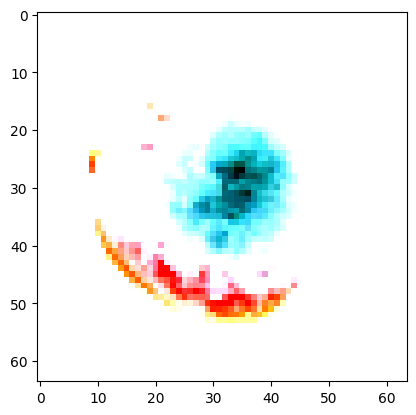

In [9]:
dataset = FruitDataset(fruit_dataframe,train_img_folder,labels=True,transform=train_transform)
dataset.generate_class_idx_map()

first_image, first_label = dataset[0]
print(first_image.shape)

#to show the image we have to conver from (C, H, W) to (H, W, C) which is expected by matplotlib
plt.imshow(first_image.permute(1,2,0))

In [10]:
arr = np.array(first_image)
arr.shape

(3, 64, 64)

In [11]:
arr[0][10:50,:]

array([[2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
        2.2489083],
       [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
        2.2489083],
       [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
        2.2489083],
       ...,
       [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
        2.2489083],
       [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
        2.2489083],
       [2.2489083, 2.2489083, 2.2489083, ..., 2.2489083, 2.2489083,
        2.2489083]], dtype=float32)

In [12]:
dataset[0][0].min(),dataset[0][0].max()

(tensor(-0.6109), tensor(2.6400))

### Create train - validation sets

In [13]:
train_dataset = FruitDataset(train_df, train_img_folder, labels=True, transform=train_transform)
train_dataset.generate_class_idx_map()
class_idx_map = train_dataset.get_class_idx_map()

valid_dataset = FruitDataset(valid_df, train_img_folder, labels=True, transform=validation_transform)
valid_dataset.set_class_idx_map(class_idx_map)

test_dataset = FruitDataset(test_df, test_img_folder, labels=True, transform=test_transform)
test_dataset.set_class_idx_map(class_idx_map)

print('Train dataset lenght:',len(train_dataset))
print('Valid dataset lenght:',len(valid_dataset))
print('test dataset lenght:',len(test_dataset))

Train dataset lenght: 846
Valid dataset lenght: 212
test dataset lenght: 453


### Create Dataloaders

In [14]:
BATCH_SIZE = 32

def create_dataloaders():
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, valid_loader , test_loader

train_loader, valid_loader, test_loader = create_dataloaders()
#train_loader, valid_loader = create_dataloaders()

#images, labels = next(iter(train_loader))
#images.shape, labels.shape


In [15]:
import torch.nn.functional as F

'''
class FruitCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(FruitCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)

        self.fc1 = nn.Linear(32*15*15,128)
        self.fc2 = nn.Linear(128,84)
        self.fc3 = nn.Linear(84,num_classes)

    def forward(self, x):
        #Original Image Input -> [channels=3,64,64]
        x = F.relu(self.conv1(x)) #->[channels=16,64,64]
        x = self.pool(x) #->[channels=16,32,32]
        x = F.relu(self.conv2(x)) #->[channels=32,30,30] is 30 because kernel_size=5 and padding=1
        x = self.pool(x) #->[channels=32,15,15]
        x = x.view(x.size(0), -1) # flatten ->[32 * 15 * 15] = [7200]
        x = F.relu(self.fc1(x)) #->[128]
        x = F.relu(self.fc2(x)) #->[84]
        x = self.fc3(x) # Number of classes ->[6]
        return x
'''

class FruitCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(FruitCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16) #Batch Normalization
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(32) #Batch Normalization

        #Pooling
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Global Pooling
        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.global_max = nn.AdaptiveMaxPool2d(1)

        #Dropout
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(64,128) #This gets doubled due to global_avg + global_max
        self.fc2 = nn.Linear(128,84)
        self.fc3 = nn.Linear(84,num_classes)

    def forward(self, x):
        #Original Image Input -> [channels=3,64,64]
        x = F.relu(self.bn1(self.conv1(x))) #->[channels=16,64,64]
        x = self.pool(x) #->[channels=16,32,32]
        
        x = F.relu(self.bn2(self.conv2(x))) #->[channels=32,30,30] is 30 because kernel_size=5 and padding=1
        x = self.pool(x) #->[channels=32,15,15]

        #Global Pooling
        avg_pooled = self.global_avg(x)
        max_pooled = self.global_max(x)
        x = torch.cat([avg_pooled, max_pooled], dim=1)

        x = x.view(x.size(0), -1) # flatten ->[64]

        x = F.relu(self.fc1(x)) #->[128]

        #Dropout
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x)) #->[84]
        x = self.fc3(x) # Number of classes ->[6]
        return x

model = FruitCNN(num_classes = 6)

In [16]:
#Sends the model to the GPU
model.to(device)

FruitCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg): AdaptiveAvgPool2d(output_size=1)
  (global_max): AdaptiveMaxPool2d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

## Training Configuration

### Parameters

In [17]:
def get_training_config():
    config = {
        'learning_rate': 0.01,
        'weight_decay': 1e-4,
        'epochs': 50,
        'min_lr': 1e-6,

        #early stop
        'patience': 7 
    }
    return config

config = get_training_config()

### Loss Function Selection

In [18]:
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)

### Optimizer Selection

In [19]:
from torch.optim import Adam

optimizer = Adam(
    model.parameters(),
    lr=config['learning_rate'], #If the learning set is not set, by default is 0.001
    weight_decay=config['weight_decay']
)

### Compute Accuracy

In [20]:
def get_batch_accuracy(output,y):
    pred = output.argmax(dim=1,keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct/output.shape[0]

In [21]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

## Define Batch/Epoch Training Class

In [22]:
def train():
    total_loss = 0
    total_accuracy = 0

    model.train()
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        #Forward pass
        output = model(x)
        batch_loss = loss_function(output,y)

        #Backward pass and optimization
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        #batch/epoch Metrics
        total_loss +=batch_loss.item()
        total_accuracy += get_batch_accuracy(output, y)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)

    print('Train - Loss: {} Accuracy: {}'.format(avg_loss, avg_accuracy))

    return avg_loss, avg_accuracy

## Define Validation

In [23]:
from tqdm import tqdm

def validate():
    total_loss = 0
    total_accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valid_loader,desc='validating'): #tdqm adds a progress bar, if not need it just use valid_loader
            x, y = x.to(device), y.to(device)
            
            output = model(x)
            batch_loss = loss_function(output, y)
            
            total_loss += batch_loss.item()
            total_accuracy += get_batch_accuracy(output, y)

    avg_loss = total_loss / len(valid_loader)
    avg_accuracy = total_accuracy / len(valid_loader)

    valid_losses.append(avg_loss)
    valid_accuracies.append(avg_accuracy)

    print('Valid - loss: {} Accuracy: {}'.format(avg_loss,avg_accuracy))

    return avg_loss, avg_accuracy

### Scheduler

In [24]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = config['epochs'],
    eta_min = config['min_lr']
)

## Train Iteration

In [25]:
epochs = config['epochs']

patience = config['patience']
epochs_no_improve = 0
early_stop = False

best_valid_accuracy = 0.0

for epoch in tqdm(range(epochs), desc='Epochs'):
    print('Epoch: {}/{}'.format(epoch + 1,epochs))

    train_loss, train_acc = train()
    valid_loss, valid_acc = validate()

    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f"Current LR: {current_lr:.6f}")

    if valid_acc > best_valid_accuracy:
        best_valid_accuracy = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

        print('Model saved! New best validation accuracy: {}'.format(best_valid_accuracy))
        epochs_no_improve = 0 #resets counter
    else:
        epochs_no_improve +=1
        print('No improve for {} epoch(s)'.format(epochs_no_improve))

    if epochs_no_improve >= patience:
        print('Early stopping triggered.')
        early_stop = True
        break


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50
Train - Loss: 1.5983413546173662 Accuracy: 0.3662367724867725



Epochs:   2%|▏         | 1/50 [00:16<13:37, 16.68s/it]

Valid - loss: 1.3893873521259852 Accuracy: 0.5
Current LR: 0.009990
Model saved! New best validation accuracy: 0.5
Epoch: 2/50
Train - Loss: 1.2855815887451172 Accuracy: 0.5686177248677249



Epochs:   4%|▍         | 2/50 [00:24<09:21, 11.70s/it]

Valid - loss: 1.2450111082621984 Accuracy: 0.5616071428571429
Current LR: 0.009961
Model saved! New best validation accuracy: 0.5616071428571429
Epoch: 3/50
Train - Loss: 1.1674258731029652 Accuracy: 0.6334325396825398



Epochs:   6%|▌         | 3/50 [00:32<07:52, 10.04s/it]

Valid - loss: 1.1817909990038191 Accuracy: 0.6205357142857143
Current LR: 0.009911
Model saved! New best validation accuracy: 0.6205357142857143
Epoch: 4/50
Train - Loss: 1.1737443054163899 Accuracy: 0.617063492063492



Epochs:   8%|▊         | 4/50 [00:40<06:47,  8.87s/it]

Valid - loss: 1.0187215294156755 Accuracy: 0.7160714285714286
Current LR: 0.009843
Model saved! New best validation accuracy: 0.7160714285714286
Epoch: 5/50
Train - Loss: 1.0876361705638744 Accuracy: 0.6798941798941799



Epochs:  10%|█         | 5/50 [00:46<06:05,  8.13s/it]

Valid - loss: 1.0854076828275407 Accuracy: 0.6589285714285714
Current LR: 0.009755
No improve for 1 epoch(s)
Epoch: 6/50
Train - Loss: 1.0819614750367623 Accuracy: 0.6939484126984127



Epochs:  12%|█▏        | 6/50 [00:53<05:38,  7.70s/it]

Valid - loss: 0.929955107825143 Accuracy: 0.7571428571428571
Current LR: 0.009649
Model saved! New best validation accuracy: 0.7571428571428571
Epoch: 7/50
Train - Loss: 1.0054584896122967 Accuracy: 0.7357804232804233



Epochs:  14%|█▍        | 7/50 [01:00<05:23,  7.52s/it]

Valid - loss: 1.0453834789139884 Accuracy: 0.7383928571428572
Current LR: 0.009524
No improve for 1 epoch(s)
Epoch: 8/50
Train - Loss: 1.0428594902709678 Accuracy: 0.7038690476190476



Epochs:  16%|█▌        | 8/50 [01:07<05:07,  7.33s/it]

Valid - loss: 0.9501462153026036 Accuracy: 0.74375
Current LR: 0.009382
No improve for 2 epoch(s)
Epoch: 9/50
Train - Loss: 0.975379021079452 Accuracy: 0.7339616402116401



Epochs:  18%|█▊        | 9/50 [01:14<04:58,  7.27s/it]

Valid - loss: 0.8655539495604379 Accuracy: 0.8196428571428571
Current LR: 0.009222
Model saved! New best validation accuracy: 0.8196428571428571
Epoch: 10/50
Train - Loss: 0.9248773985438876 Accuracy: 0.7731481481481481



Epochs:  20%|██        | 10/50 [01:22<04:49,  7.23s/it]

Valid - loss: 0.8524717177663531 Accuracy: 0.7723214285714286
Current LR: 0.009045
No improve for 1 epoch(s)
Epoch: 11/50
Train - Loss: 0.9577104714181688 Accuracy: 0.7574404761904762



Epochs:  22%|██▏       | 11/50 [01:29<04:43,  7.26s/it]

Valid - loss: 0.8429861068725586 Accuracy: 0.8258928571428571
Current LR: 0.008853
Model saved! New best validation accuracy: 0.8258928571428571
Epoch: 12/50
Train - Loss: 0.8686442088197779 Accuracy: 0.800595238095238



Epochs:  24%|██▍       | 12/50 [01:36<04:38,  7.32s/it]

Valid - loss: 0.7949494293757847 Accuracy: 0.8330357142857142
Current LR: 0.008645
Model saved! New best validation accuracy: 0.8330357142857142
Epoch: 13/50
Train - Loss: 0.8800289167298211 Accuracy: 0.7906746031746031



Epochs:  26%|██▌       | 13/50 [01:44<04:29,  7.27s/it]

Valid - loss: 0.7619593143463135 Accuracy: 0.8508928571428571
Current LR: 0.008423
Model saved! New best validation accuracy: 0.8508928571428571
Epoch: 14/50
Train - Loss: 0.8365256742194846 Accuracy: 0.820436507936508



Epochs:  28%|██▊       | 14/50 [01:51<04:21,  7.27s/it]

Valid - loss: 0.7797362293515887 Accuracy: 0.8508928571428571
Current LR: 0.008187
No improve for 1 epoch(s)
Epoch: 15/50
Train - Loss: 0.8647015160984464 Accuracy: 0.7991071428571429



Epochs:  30%|███       | 15/50 [02:01<04:43,  8.10s/it]

Valid - loss: 0.8297701818602425 Accuracy: 0.8169642857142857
Current LR: 0.007939
No improve for 2 epoch(s)
Epoch: 16/50
Train - Loss: 0.8350014178841202 Accuracy: 0.8086970899470899



Epochs:  32%|███▏      | 16/50 [02:09<04:33,  8.06s/it]

Valid - loss: 0.7678213971001762 Accuracy: 0.8419642857142857
Current LR: 0.007679
No improve for 3 epoch(s)
Epoch: 17/50
Train - Loss: 0.8487233607857315 Accuracy: 0.808862433862434



Epochs:  34%|███▍      | 17/50 [02:16<04:16,  7.76s/it]

Valid - loss: 0.8251741187913078 Accuracy: 0.8267857142857142
Current LR: 0.007409
No improve for 4 epoch(s)
Epoch: 18/50
Train - Loss: 0.8082721564504836 Accuracy: 0.8265542328042328



Epochs:  36%|███▌      | 18/50 [02:23<04:01,  7.56s/it]

Valid - loss: 0.7167331320898873 Accuracy: 0.8616071428571429
Current LR: 0.007129
Model saved! New best validation accuracy: 0.8616071428571429
Epoch: 19/50
Train - Loss: 0.7619610185976382 Accuracy: 0.8468915343915343



Epochs:  38%|███▊      | 19/50 [02:30<03:49,  7.41s/it]

Valid - loss: 0.7040041599954877 Accuracy: 0.8616071428571429
Current LR: 0.006841
No improve for 1 epoch(s)
Epoch: 20/50
Train - Loss: 0.7094698437937984 Accuracy: 0.8758267195767195



Epochs:  40%|████      | 20/50 [02:37<03:38,  7.29s/it]

Valid - loss: 0.7133983288492475 Accuracy: 0.8616071428571429
Current LR: 0.006545
No improve for 2 epoch(s)
Epoch: 21/50
Train - Loss: 0.7604068142396433 Accuracy: 0.8396164021164021



Epochs:  42%|████▏     | 21/50 [02:44<03:27,  7.15s/it]

Valid - loss: 0.739326366356441 Accuracy: 0.8839285714285714
Current LR: 0.006244
Model saved! New best validation accuracy: 0.8839285714285714
Epoch: 22/50
Train - Loss: 0.763482149000521 Accuracy: 0.8501984126984127



Epochs:  44%|████▍     | 22/50 [02:51<03:17,  7.06s/it]

Valid - loss: 0.7170176676341465 Accuracy: 0.8794642857142857
Current LR: 0.005937
No improve for 1 epoch(s)
Epoch: 23/50
Train - Loss: 0.69542396068573 Accuracy: 0.8804563492063492



Epochs:  46%|████▌     | 23/50 [02:58<03:09,  7.01s/it]

Valid - loss: 0.689808326108115 Accuracy: 0.8866071428571428
Current LR: 0.005627
Model saved! New best validation accuracy: 0.8866071428571428
Epoch: 24/50
Train - Loss: 0.7165152408458568 Accuracy: 0.8659060846560847



Epochs:  48%|████▊     | 24/50 [03:05<03:02,  7.01s/it]

Valid - loss: 0.6830840025629316 Accuracy: 0.8910714285714285
Current LR: 0.005314
Model saved! New best validation accuracy: 0.8910714285714285
Epoch: 25/50
Train - Loss: 0.6949655612309774 Accuracy: 0.884755291005291



Epochs:  50%|█████     | 25/50 [03:12<02:55,  7.03s/it]

Valid - loss: 0.6658487234796796 Accuracy: 0.9089285714285714
Current LR: 0.005001
Model saved! New best validation accuracy: 0.9089285714285714
Epoch: 26/50
Train - Loss: 0.6890937354829576 Accuracy: 0.882771164021164



Epochs:  52%|█████▏    | 26/50 [03:19<02:48,  7.03s/it]

Valid - loss: 0.6851159249033246 Accuracy: 0.8535714285714285
Current LR: 0.004687
No improve for 1 epoch(s)
Epoch: 27/50
Train - Loss: 0.6677225474958066 Accuracy: 0.8928571428571429



Epochs:  54%|█████▍    | 27/50 [03:26<02:42,  7.05s/it]

Valid - loss: 0.6505511317934308 Accuracy: 0.9089285714285714
Current LR: 0.004374
No improve for 2 epoch(s)
Epoch: 28/50
Train - Loss: 0.6695450213220384 Accuracy: 0.9012896825396824



Epochs:  56%|█████▌    | 28/50 [03:33<02:35,  7.06s/it]

Valid - loss: 0.6492303950445992 Accuracy: 0.9089285714285714
Current LR: 0.004064
No improve for 3 epoch(s)
Epoch: 29/50
Train - Loss: 0.683586785086879 Accuracy: 0.8902116402116401



Epochs:  58%|█████▊    | 29/50 [03:40<02:29,  7.11s/it]

Valid - loss: 0.6513458490371704 Accuracy: 0.8910714285714285
Current LR: 0.003757
No improve for 4 epoch(s)
Epoch: 30/50
Train - Loss: 0.6885704950050071 Accuracy: 0.8850859788359787



Epochs:  60%|██████    | 30/50 [03:47<02:20,  7.04s/it]

Valid - loss: 0.6969656092779977 Accuracy: 0.8803571428571428
Current LR: 0.003456
No improve for 5 epoch(s)
Epoch: 31/50
Train - Loss: 0.6426389228414606 Accuracy: 0.9059193121693121



Epochs:  62%|██████▏   | 31/50 [03:54<02:13,  7.00s/it]

Valid - loss: 0.6353007299559457 Accuracy: 0.8937499999999999
Current LR: 0.003160
No improve for 6 epoch(s)
Epoch: 32/50
Train - Loss: 0.6641996613255253 Accuracy: 0.8940145502645502



Epochs:  62%|██████▏   | 31/50 [04:01<02:27,  7.78s/it]

Valid - loss: 0.6309095621109009 Accuracy: 0.9044642857142857
Current LR: 0.002872
No improve for 7 epoch(s)
Early stopping triggered.


In [37]:
model.load_state_dict(torch.load('best_model.pth',weights_only=False))

len(train_losses)

32

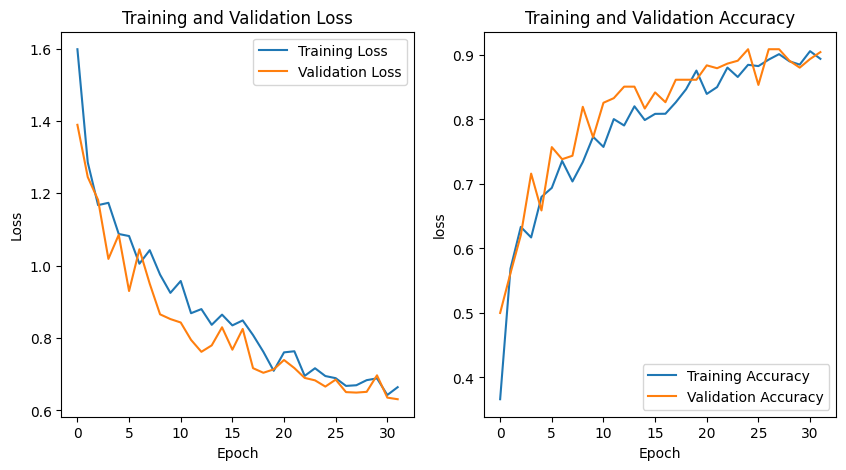

Loaded best model with validation accuracy: 0.9089285714285714


In [38]:
epochs_range = range(len(train_losses))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs_range,train_losses, label='Training Loss')
plt.plot(epochs_range,valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,train_accuracies,label='Training Accuracy')
plt.plot(epochs_range,valid_accuracies,label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

print('Loaded best model with validation accuracy: {}'.format(best_valid_accuracy))

## Submission presentation
### Submission evaluation

In [28]:
#Evaluate data in test set
model.eval()
predictions = []

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs,1)
        predictions.extend(preds.cpu().numpy())


### Submission Preparation

In [33]:
#Prepare submission

predictions_labels = []
'''
submission = pd.DataFrame({
    'Id': np.arange(1, len(predictions) + 1), 
    'Label': predictions
})
'''
map_idx = list(class_idx_map.values())
map_class = list(class_idx_map.keys())

for pred in predictions:
    predictions_labels.append(map_class[map_idx.index(pred)])

submission = pd.DataFrame({
    'Id': test_df['filename'].values, 
    'Label': predictions_labels
})

### Submission File Generation

In [32]:
submission.to_csv('submission.csv',index=False)

print("Submission file created: 'submission.csv'")